# shapefiles ----------

In [1]:
!pip install pyshp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.6 MB/s eta 0:00:00


# Import Packages

In [2]:
import shapefile
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
from matplotlib.cm import *
from IPython.display import Image as ImageShow

# Create a shapefile object

In [9]:
#   -- input --
sf = shapefile.Reader(r'../shapefiles/oum_rabia_utm/BVOER_UTM29N')

In [12]:
print ('number of shapes imported: ', len(sf.shapes()))

number of shapes imported:  1


# Reading Geometry

Get the list of the shapefile's geometry by calling the shapes() method


The shapes method returns a list of Shape objects describing the geometry of each shape record


In [13]:
shapes  = sf.shapes()
shapes

Shapes: [Shape #0: POLYGON]

In [14]:
len(shapes)

1

Each shape record contains the following attributes


In [18]:
for name in dir(shapes[0]):
    if not name.startswith('__'):
        print (name)

_Shape__oid
_errors
_from_geojson
bbox
oid
parts
points
shapeType
shapeTypeName


shapeType: an integer representing the type of shape as defined by the shapefile specification.


In [20]:
shapes[0].shapeType


5

bbox: If the shape type contains multiple points this tuple describes the lower left (x,y) coordinate and upper right corner coordinate creating a complete box around the points. If the shapeType is a Null (shapeType == 0) then an AttributeError is raised.


In [22]:
# Get the bounding box of the 1st shape.
# Round coordinates to 3 decimal places
bbox = shapes[0].bbox
print (['%.3f' % coord for coord in bbox])

['559580.803', '3468787.654', '867611.363', '3687962.806']


parts: Parts simply group collections of points into shapes. If the shape record has multiple parts this attribute contains the index of the first point of each part. If there is only one part then a list containing 0 is returned.


In [23]:
shapes[0].parts

[0]

points: The points attribute contains a list of tuples containing an (x,y) coordinate for each point in the shape.


In [26]:
len(shapes[0].points)

3548

# Reading Records


* A record in a shapefile contains the attributes for each shape in the collection of geometry.
*  Records are stored in the dbf file.
* The link between geometry and attributes is the foundation of all geographic information systems.
* This critical link is implied by the order of shapes and corresponding records in the shp geometry file and the dbf attribute file.


The field names of a shapefile are available as soon as you read a shapefile. You can call the “fields” attribute of the shapefile as a Python list. Each field is a Python list with the following information:

* Field name: the name describing the data at this column index.
* Field type: the type of data at this column index. Types can be: Character, Numbers, Longs, Dates, or Memo.
* Field length: the length of the data found at this column index.
* Decimal length: the number of decimal places found in “Number” fields.

In [27]:
recs = sf.records()
len(recs)

1

Each record is a list containing an attribute corresponding to each field in the field list.


In [29]:
recs[0][:]

[1, 'BV. Oum Er Rabia', 1242864.71428, 34992383754.7]

# Plotting a simple record

In [32]:
# Get all the information for a single shape(in this case, the 1st shape)
shape_ex = sf.shape(0)

In [37]:
len(shape_ex.points)

3548

The points attribute contains a list of latitude-longitude values that define the shape (state) boundary.

* Loop over those points to create an array of longitude and latitude values to plot.
* A single point can be accessed with shape_ex.points[0] and will return a lon/lat pair, e.g. (-70.13123,40.6210). * Pull out the first and second index and put them in pre-defined numpy arrays:

In [52]:
def plot_one_shp_bassin(sf):
    
    shape_ex = sf.shape(0)
    x_lon = np.zeros((len(shape_ex.points), 1))
    y_lat = np.zeros((len(shape_ex.points), 1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    

        #   -- plot --
    fig     = plt.figure()
    ax      = fig.add_subplot(111)
    ax.get_yaxis().set_visible(True)
    ax.get_xaxis().set_visible(True)
    ax.set_frame_on(False)
    plt.plot(x_lon,y_lat,'k')

    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])

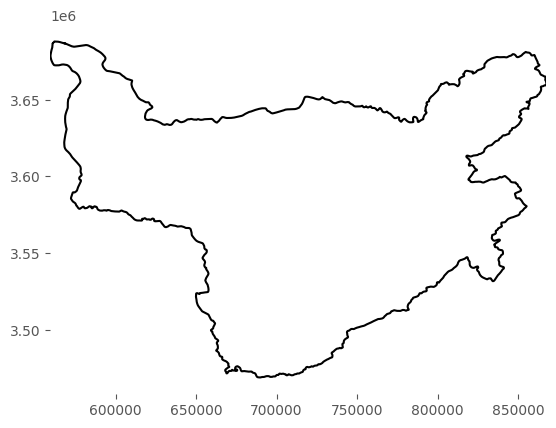

In [53]:
plot_one_shp(sf)

In [54]:
def plot_all_shp_bassins(sf):

    #   -- plot --
    fig     = plt.figure()
    ax      = fig.add_subplot(111)
    ax.get_yaxis().set_visible(True)
    ax.get_xaxis().set_visible(True)
    ax.set_frame_on(False)

    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y)

    plt.show()

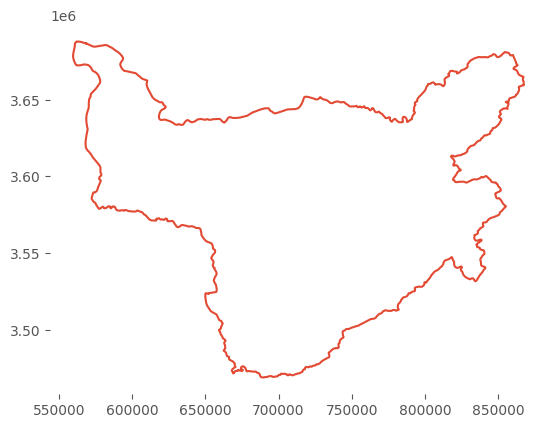

In [55]:
plot_all_shp_graphs(sf)


# cliping

## using rioxarray

In [64]:
# !pip install rioxarray

In [65]:
# !pip install geopandas

In [67]:
# !pip install rasterio

In [58]:
def cliping_netcdf(nc_file_path,shapefile_path,nc_file_name):
    import geopandas as gpd
    import xarray as xr 
    from shapely.geometry import mapping

    shp = gpd.read_file(shapefile_path)
    nc_file = xr.open_dataset(nc_file_path)
    
    shp_crs = shp.crs

    print("crs from shapefile :-------------:  ",shp_crs)
    print("crs from nc file :-------------:  ",nc_file.rio.crs)


    # For netcdf files:
#     nc_file.rio.write_crs('EPSG:4326', inplace = True)
    nc_file.rio.write_crs(shp_crs, inplace = True)
    # For shapefile:
    # sf.crs='EPSG:4326'
    # sf.set_crs('EPSG:4326', inplace = True, allow_override = True)


    print("crs from shapefile 2:-------------:  ",shp_crs)
    print("crs from nc file   2:-------------:  ",nc_file.rio.crs)

    
    
    # Clip the NetCDF file using the shapefile geometry
    clipped_nc = nc_file.rio.clip(shp.geometry.apply(mapping), all_touched=True)
    
    # Remove NAN values
    
    # nan values are diffecult to remove in case of netcdf file , so as a solution we can replace nan values
    # with other cammon value sach as 999999 
    
    # save clipped_nc 
#     clipped_nc.to_netcdf(nc_file_name+'_clipped.nc')
    print(",clping successefuly end !")
    return clipped_nc


# TEST


In [63]:
# shapefile_path = '../shapefiles/oum_rabia_utm/BVOER_UTM29N.shp'
shapefile_path = '../shapefiles/masira/BV_EL_Massira.shp'
nc_file_path = 'data_3.nc'

nc_clipped_file = cliping_netcdf(nc_file_path,shapefile_path,'sssss')

crs from shapefile :-------------:   EPSG:4326
crs from nc file :-------------:   None
crs from shapefile 2:-------------:   EPSG:4326
crs from nc file   2:-------------:   EPSG:4326
,clping successefuly end !


In [64]:
nc_clipped_file

<xarray.Dataset>
Dimensions:      (longitude: 29, latitude: 20, time: 7670)
Coordinates:
  * longitude    (longitude) float32 -7.87 -7.77 -7.67 ... -5.27 -5.17 -5.07
  * latitude     (latitude) float32 33.23 33.13 33.03 ... 31.53 31.43 31.33
  * time         (time) datetime64[ns] 2002-01-01T12:00:00 ... 2022-12-31T12:...
    spatial_ref  int64 0
Data variables:
    smlt         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-30 12:39:23 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

# Handle NAN values (getting after netcdf clipping)

nan values are diffecult to remove in case of netcdf file , so as a solution we can replace nan values
with other cammon value sach as 999999 
    

In [71]:
nc_clipped_file = clipped_nc

In [72]:
xr_data = xr.Dataset(clipped_nc)

In [73]:
import numpy as np
import xarray as xr

# xr_data = xr_data.dropna(dim="latitude",subset=['tp'])
xr_data = xr_data.fillna(999999)



In [74]:
xr_data

<xarray.Dataset>
Dimensions:      (time: 7670, latitude: 20, longitude: 29)
Coordinates:
  * longitude    (longitude) float32 -7.86 -7.76 -7.66 ... -5.26 -5.16 -5.06
  * latitude     (latitude) float32 33.23 33.13 33.03 ... 31.53 31.43 31.33
  * time         (time) datetime64[ns] 2002-01-01T12:00:00 ... 2022-12-31T12:...
    spatial_ref  int64 0
Data variables:
    tp           (time, latitude, longitude) float64 1e+06 1e+06 ... 1e+06 1e+06

In [70]:
xr_data = xr_data.to_dataframe()
xr_data.head()

tp  spatial_ref
time                latitude longitude                       
2002-01-01 12:00:00 33.23    -7.86      999999.0            0
                             -7.76      999999.0            0
                             -7.66      999999.0            0
                             -7.56      999999.0            0
                             -7.46      999999.0            0

In [56]:
# temperature = [
#     [0, 4, 2, 9],
#     [np.nan, np.nan, np.nan, np.nan],
#     [np.nan, 4, 2, 0],
#     [3, 1, 0, 0],
# ]

# da = xr.DataArray(
#     data=temperature,
#     dims=["Y", "X"],
#     coords=dict(
#         lat=("Y", np.array([-20.0, -20.25, -20.50, -20.75])),
#         lon=("X", np.array([10.0, 10.25, 10.5, 10.75])),
#     ),
# )

# da

In [55]:
# da.dropna(dim="Y", how="any")

In [54]:
# da.dropna(dim="X", how="any")

# Geopandas ----------